In [106]:
import os
import sys
from glob import glob
from pathlib import Path
from tqdm import tqdm
from dotenv import load_dotenv

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy
import h5py

from sklearn.model_selection import LeaveOneGroupOut
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate

from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from sklearn.linear_model import SGDClassifier
from sklearn.utils import shuffle

Size of coefficient is indicative of its importance. We can use odds ratio to get an even better measure of how important each coefficient is. The relationship between the coefficient absolute value and its odds ratio is logarithmic. 

Whether the coefficient is positive or negative indicates whether it increases or decreases the chance that the class in question will be classified. 

In [107]:
module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [108]:
from global_config import ROOT_DIR, emotion_id_to_emotion
from feature_names import *
from src.utils.helpers import mapper

In [109]:
input_path = os.path.join(ROOT_DIR,'files/out/functionals/video_data_functionals_A220.hdf5')
output_path = os.path.join(ROOT_DIR,'files/out/functionals/supervised_learning/video')

In [110]:
f = h5py.File(input_path, 'r')
_X = f['x']
y = f['y']
groups = f['groups']
feature_names = f['feature_names'].asstr()
for k in f.attrs.keys():
    print(f"{k} : {f.attrs[k]}")

group_type : twinned


In [111]:
n_groups = len(np.unique(groups))
n_features = X.shape[1]
n_classes = len(np.unique(y))

In [112]:
scaler = MinMaxScaler()
X = scaler.fit_transform(_X)

In [113]:
def get_highest_values(arr):
    raveled = arr.ravel()
    ind = raveled.argsort()
    return raveled[ind[-20:]]

In [114]:
clf = SGDClassifier(loss = "log")
coeffs = np.zeros((n_classes, n_features))

logo = LeaveOneGroupOut()
for train_idx, val_idx in logo.split(X, y, groups):
    X_train, X_val, y_train, y_val = X[train_idx], X[val_idx], y[train_idx], y[val_idx]
    
    clf.fit(X_train, y_train)
        
    coeffs += clf.coef_
    
coeffs = coeffs / n_groups

In [115]:
mat = pd.DataFrame(coeffs.T, feature_names, list(emotion_id_to_emotion.values()))
mat = mat.rename(var_name_to_feat, axis=0)

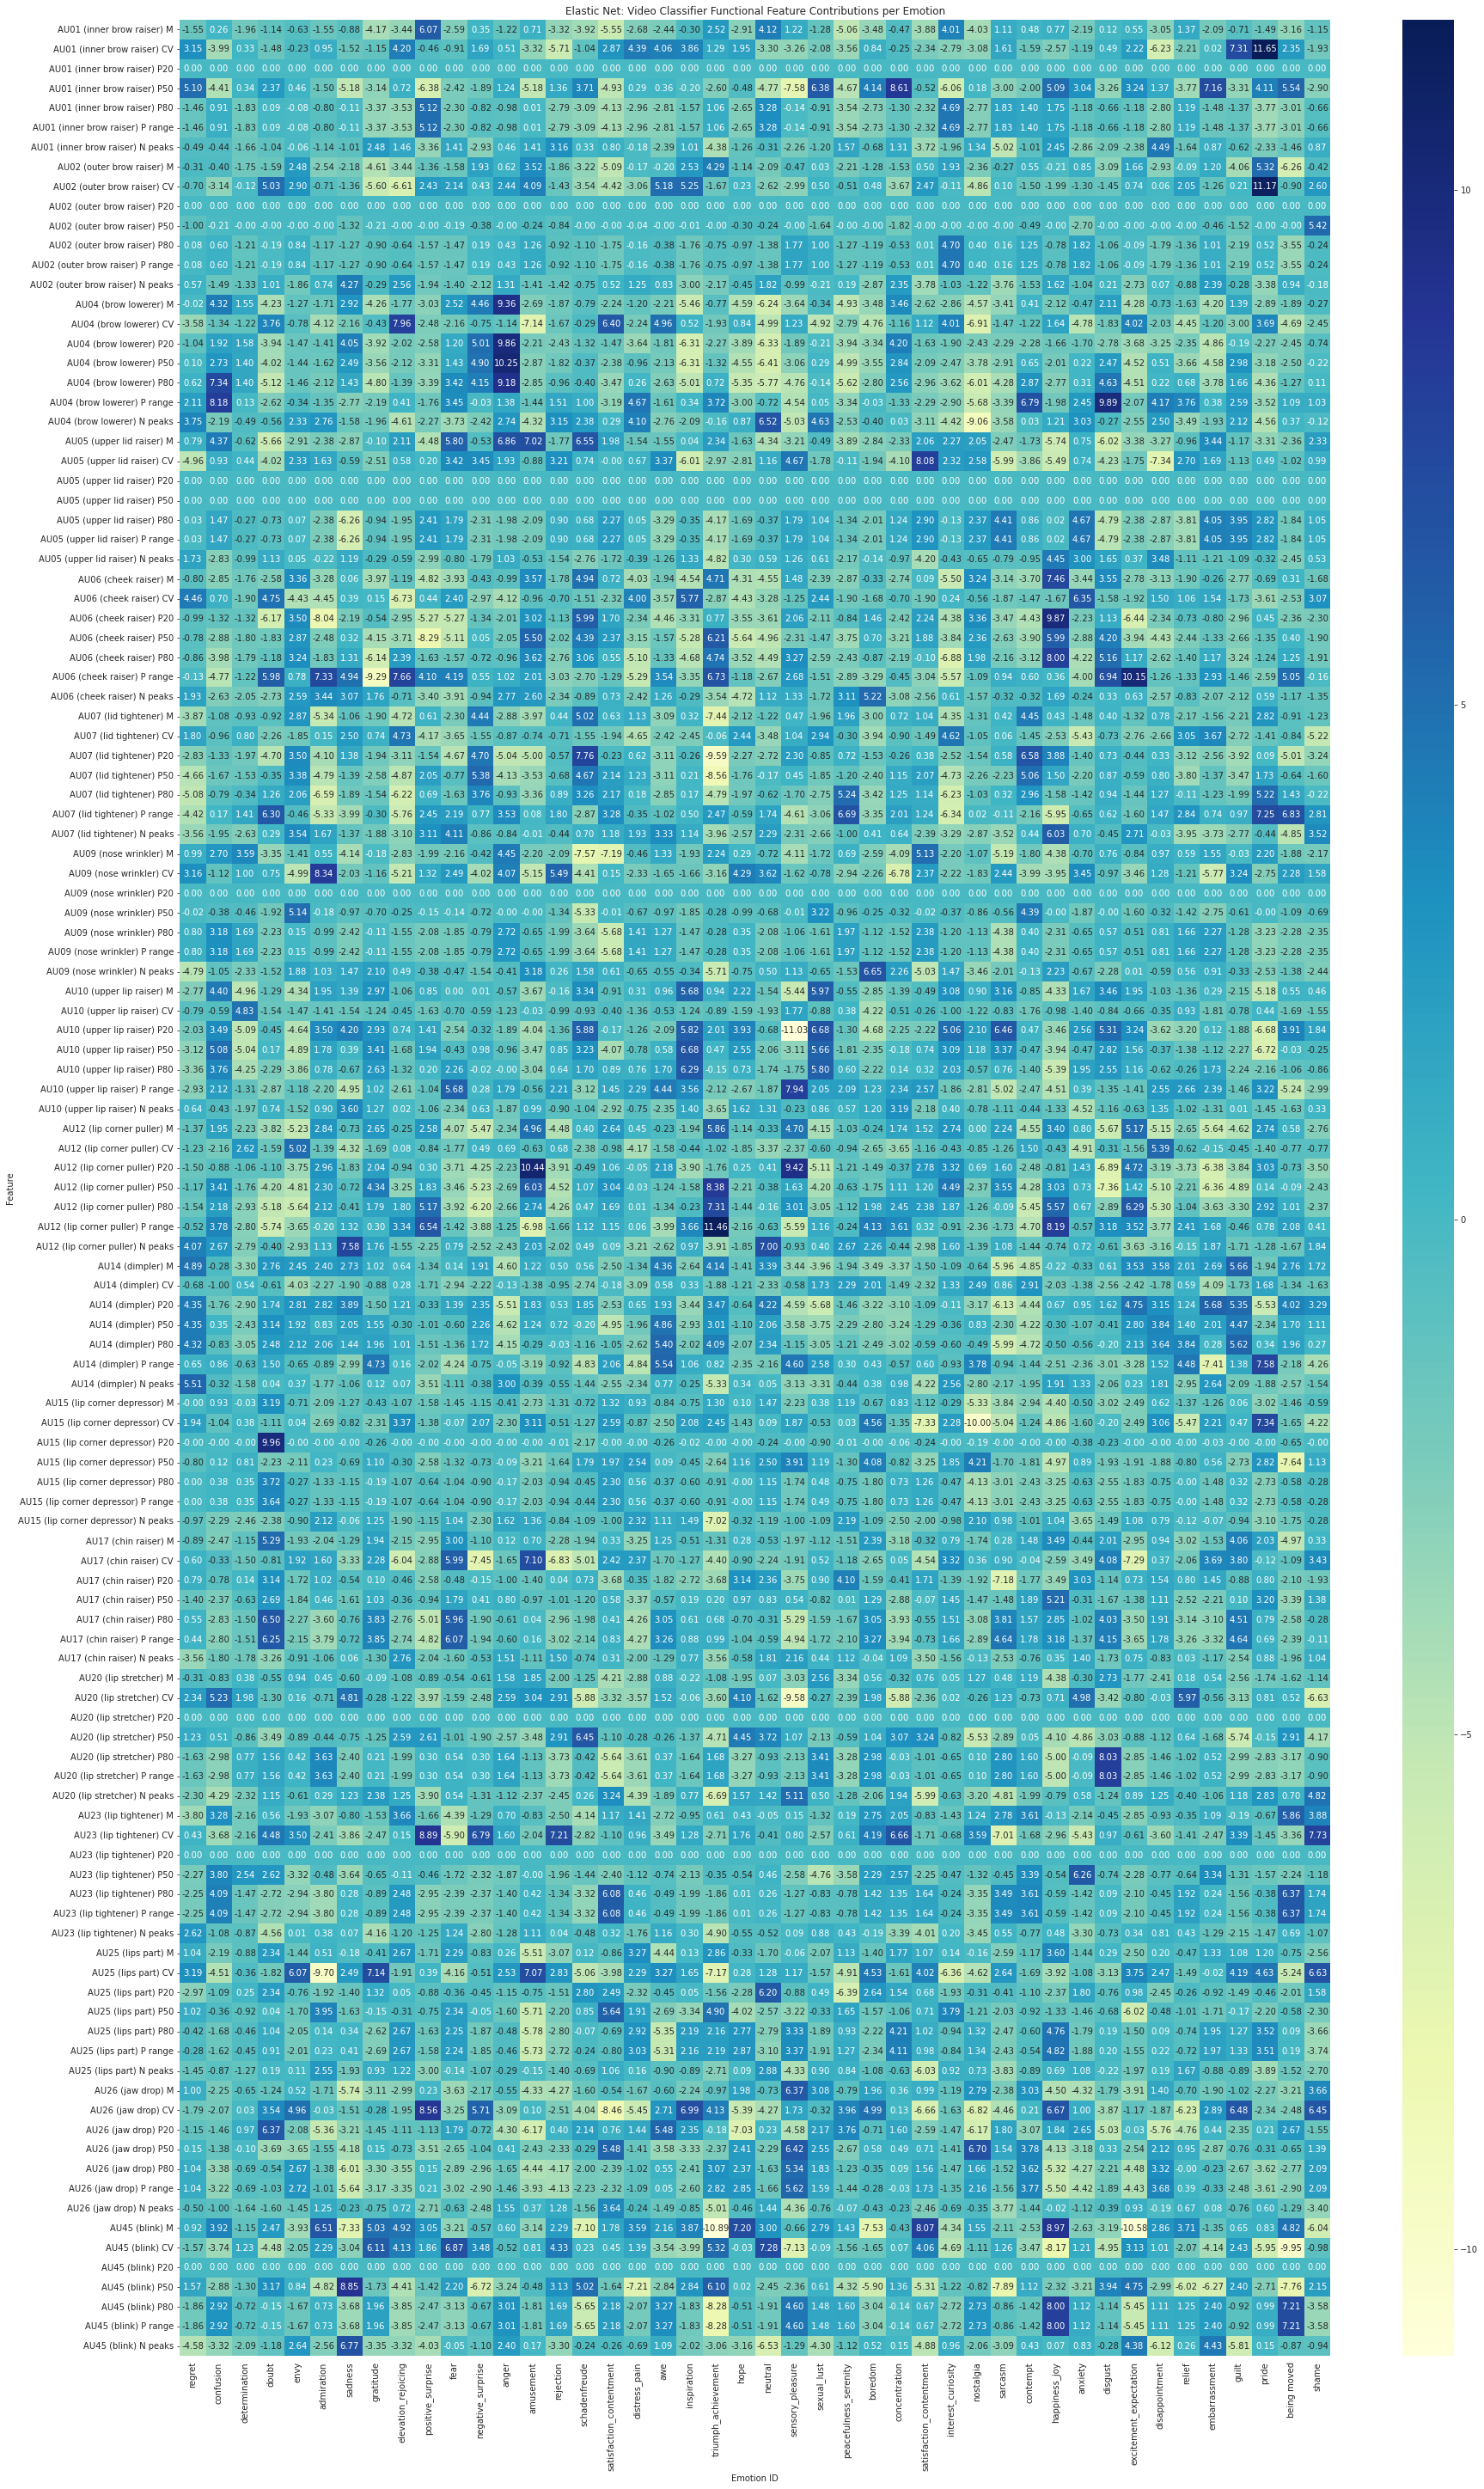

In [116]:
# Plot results
sns.set_style({'ytick.left': True})

plt.figure(figsize=(30,50))
ax = sns.heatmap(mat, cmap="YlGnBu", annot=True, fmt='.2f', cbar_kws={"aspect": 45})
plt.yticks(va='center')
plt.xlabel('Emotion ID')
plt.ylabel('Feature')


plt.savefig(os.path.join(output_path,'others','logistic_regression_contributions.svg'), bbox_inches = 'tight')

plt.title('Elastic Net: Video Classifier Functional Feature Contributions per Emotion')

plt.show()
sns.set_style({'ytick.left': False})

In [117]:
top_list = []
top_indices_list = []
n = 2
for target in coeffs:
    # get sorted index (based on absolute values)
    index = np.argsort(np.abs(target))
    top_n_index = index[-n:]
    
    # select n highest values
    top_n = target[top_n_index]
    
    top_indices_list.append(top_n_index)
    top_list.append(top_n)
    
top = np.array(top_list)
top_indices = np.array(top_indices_list)

In [118]:
top_coeffs = np.zeros((coeffs.shape))
for idx in range(top_coeffs.shape[0]):
    top_coeffs[idx, top_indices[idx]] = top[idx]
top_coeffs[top_coeffs == 0] = np.NaN

In [119]:
top_mat = pd.DataFrame(top_coeffs.T, feature_names, list(emotion_id_to_emotion.values()))
top_mat = top_mat.dropna(axis = 0, how = 'all')
top_mat = top_mat.rename(var_name_to_feat, axis=0)

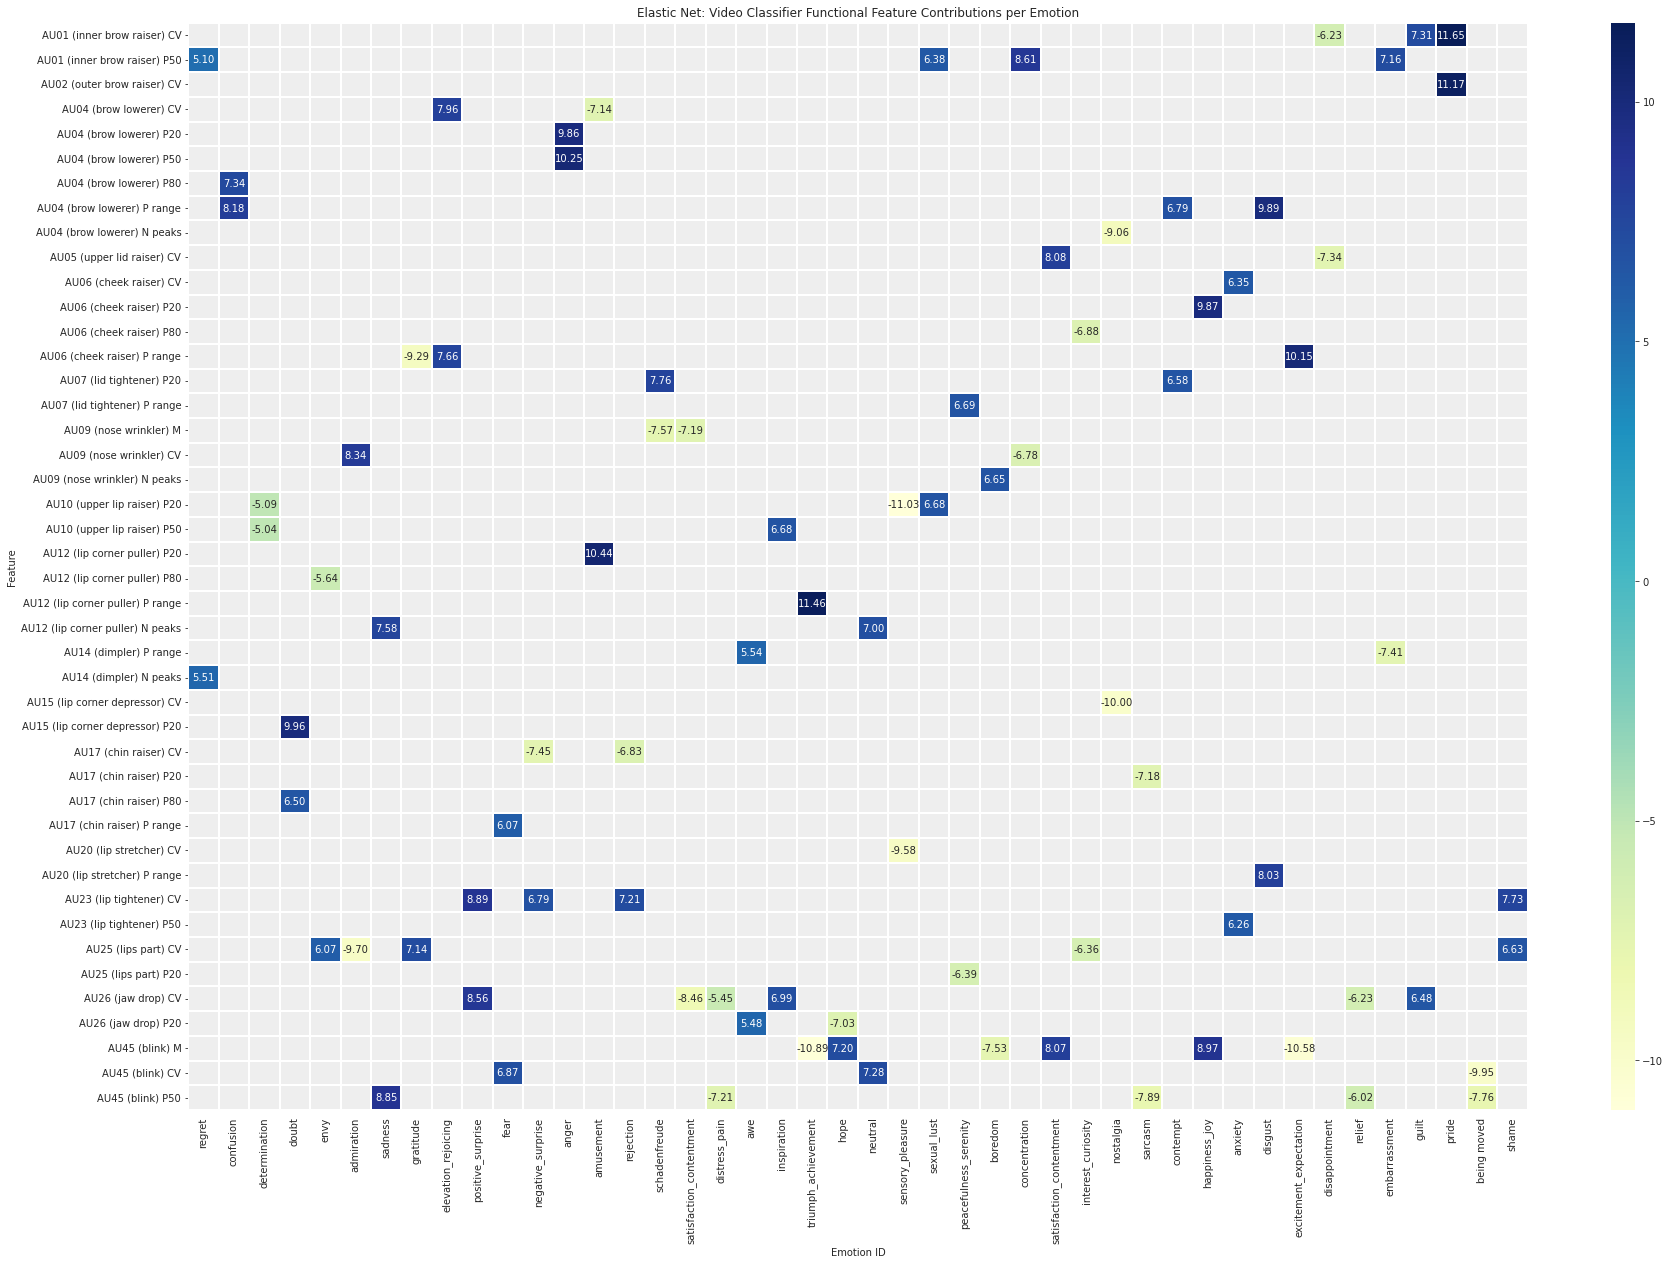

In [120]:
# Plot results
sns.set_style({'ytick.left': True})

plt.figure(figsize=(30, 20))
hm = sns.heatmap(top_mat, cmap="YlGnBu", annot=True, fmt='.2f', cbar_kws={"aspect": 45}, linewidth=0.25)
plt.yticks(va='center')
plt.xlabel('Emotion ID')
plt.ylabel('Feature')

ax = hm.axes
ax.set_facecolor((238/255, 238/255, 238/255))

plt.savefig(os.path.join(output_path,'others','logistic_regression_contributions_top_'+str(n)+'.svg'), bbox_inches = 'tight')

plt.title('Elastic Net: Video Classifier Functional Feature Contributions per Emotion')

sns.set_style({'ytick.left': False})
plt.show()
